#### Imports and Inital Functions

In [3]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import pandas as pd

from environment import (
    State,
    TraceConditioningTrial,
    one_hot, 
    geometric_dwell,
    concat_experiences,
)
from drn_encoder import neural_filter
from util import stack_trials, normative_value
from true_online_distributional_TD import heterogeneous_discount_true_online_td

plt.style.use('publication_style.mplrc')

In [4]:
plt.rcParams.update({
    "font.size": 16,        # base font
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

In [5]:
def discount_to_time_const(discounting_factor, dt):
    return -dt / np.log(discounting_factor)

In [6]:
cmap = plt.cm.plasma

In [7]:
class YlimFixer:
    """
    Taken from:
    Harkin, E. F., Grossman, C. D., Cohen, J. Y., Béïque, J.-C., & Naud, R. (2025).
    A prospective code for value in the serotonin system.
    Nature, 641, 952–960. https://doi.org/10.1038/s41586-025-08731-7
    """
    def __init__(self, y, label_bar_height=0.05, label_bar_pad=0.025, bottom_pad=0.025):
        y_min, y_max = np.nanmin(y), np.nanmax(y)
        y_range = y_max - y_min
        label_bar_height = label_bar_height * y_range
        label_bar_pad = label_bar_pad * y_range
        self._label_bar_bottom = y_max + label_bar_pad
        self._label_bar_top = y_max + label_bar_pad + label_bar_height
        bottom_pad = bottom_pad * y_range
        self._ylim = (
            y_min - bottom_pad, 
            self._label_bar_top
        )
    
    def fix_ylim(self, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.set_ylim(self._ylim)
    
    def label_bar_bottom(self):
        return self._label_bar_bottom
    
    def label_bar_top(self):
        return self._label_bar_top

### Setting up Environment and ITI 

**Taken from:**

Harkin, E. F., Grossman, C. D., Cohen, J. Y., Béïque, J.-C., & Naud, R. (2025).
A prospective code for value in the serotonin system.
Nature, 641, 952–960. https://doi.org/10.1038/s41586-025-08731-7

- Kept the Environment file the same as the Prospective Code for value paper
- Simulated a Trace Conditioning Trial: 
    - TraceConditioningTrial(cs_length, trace_length, us_length, us_value, base_state)
    - CS (Cue State), then US (reward)
    - Trial.ground_truth() gives a full serial compound: one state per timestep with labels cs, trace, us.

- Between Trial, simulates an exponentially distribuited ITI using:
    - geometric_dwell(base_state, 0.0, mean_dwell_time=ITI_LEN_TIMESTEPS)
    - geometric_dwell samples a dwell time from a geometric distribution (in continous time this is an exponential waiting time)
    - This makes ITI memoryless, which is exactly what is wanted. There is no predictable structure in ITI, so the agent shoudn't ramp up then. 

- A long experience is built by alternating:
    - iti experience -> trial.ground_truth() -> iti experience -> trial.ground_truth() ...

- Then the states are converted to one-hot features so true_online_td can use them.

In [8]:
NUM_TRIALS = 500
DT = 0.05

In [9]:
def set_up_trace_conditioning_simulation():
    iti_state = State(0, 'iti')
    trial = TraceConditioningTrial(
        cs_length=1.0 /DT,
        trace_length=2.0 /DT,
        us_length=1.0 /DT,
        us_value=1.0 *DT,
        base_state=1,
    )

    iti_len_timesteps = len(trial) * 2

    def simulate_trace_conditioning(
        base_state: State,
        trial: TraceConditioningTrial,
    ) -> dict:
        experiences = []
        for _ in trange(NUM_TRIALS, desc='Simulating trials', leave=False):
            experiences.append(
                geometric_dwell(
                    base_state, 0.0, mean_dwell_time= iti_len_timesteps
                )
            )
            experiences.append(trial.ground_truth())
        return concat_experiences(experiences)

    np.random.seed(36)
    experience = simulate_trace_conditioning(iti_state, trial)
    state_matrix = one_hot(experience, (0, len(trial) + 1)) #( T, num_states )
    rewards = experience.rewards

    return experience, state_matrix, rewards, trial, iti_state

# 1. Discount Factor Asymmetry in TD updates

In [9]:
# Set up simulation
experience, state_matrix, rewards, trial, iti_state = set_up_trace_conditioning_simulation()
iti_len_timesteps = len(trial) * 2

# Discount factor used for normative reference
gamma_norm = 0.99

# Convert discount factor to continuous-time discounting timescale
tau_discount_norm = discount_to_time_const(gamma_norm,DT)

# Analytic / normative value function
v_norm = normative_value(
    experience,
    iti_state,
    trial,
    iti_len_timesteps *DT,
    tau_discount_norm,
   DT,
)

K = 7

# Discounting timescales (seconds or time units, NOT expectiles)
discount_timescales = np.logspace(-1, 1.0, K)

gamma_td = 0.99
lambda_td = 0.99
alpha_td = 0.01

# True-online TD with heterogeneous discounting
dist_result = heterogeneous_discount_true_online_td(
    state_matrix=state_matrix,
    rewards=rewards,
    taus=discount_timescales,  # discounting timescales τ_k
    dt=DT,                     # timestep size
    lambda_=lambda_td,
    learning_rate=alpha_td,
)



colors = [cmap(i / max(1, len(discount_timescales) - 1)) for i in range(len(discount_timescales))]

Simulating trials:   0%|          | 0/500 [00:00<?, ?it/s]

### Setting up the values for the graphs below 

In [9]:
baseline_duration = 10   # steps before cue to show baseline value
trial_t = (np.arange(len(trial) + 20) - 10) *DT

              
values = dist_result.values               # shape (T, K)

mean_norm_trials = []
mean_td_trials   = []
error_trials     = []
rmse_per_tau     = []

# 1) Normative value stacked by trial  (only once)
stacked_norm = stack_trials(
    v_norm,                # shape (T,)
    experience.states,
    iti_state,
    len(trial),
    baseline_duration,
)  # shape (num_trials, T_within_trial)

mean_norm = np.nanmean(stacked_norm, axis=0)
mean_norm_trials.append(mean_norm)
K = values.shape[1]

for k in range(K):
    tau_k = discount_timescales[k]
    td_k  = values[:, k]   # time series for channel k, shape (T,)

    # 2) TD-learned value stacked by trial for this channel
    stacked_td = stack_trials(
        td_k,
        experience.states,
        iti_state,
        len(trial),
        baseline_duration,
    )  # shape (num_trials, T_within_trial)

    mean_td = np.nanmean(stacked_td, axis=0)

    # 3) Error (TD – normative) for this channel
    err = mean_td - mean_norm

    # 4) Scalar error summary for this channel (RMSE over time)
    rmse = np.sqrt(np.nanmean(err**2))

    mean_td_trials.append(mean_td)
    error_trials.append(err)
    rmse_per_tau.append(rmse)

mean_norm_trials = np.array(mean_norm_trials)    # shape (1, T_within_trial)
mean_td_trials   = np.array(mean_td_trials)      # shape (K, T_within_trial)
error_trials     = np.stack(error_trials, axis=0)  # shape (K, T_within_trial)
rmse_per_tau     = np.array(rmse_per_tau)          # shape (K,)

## Figure 4

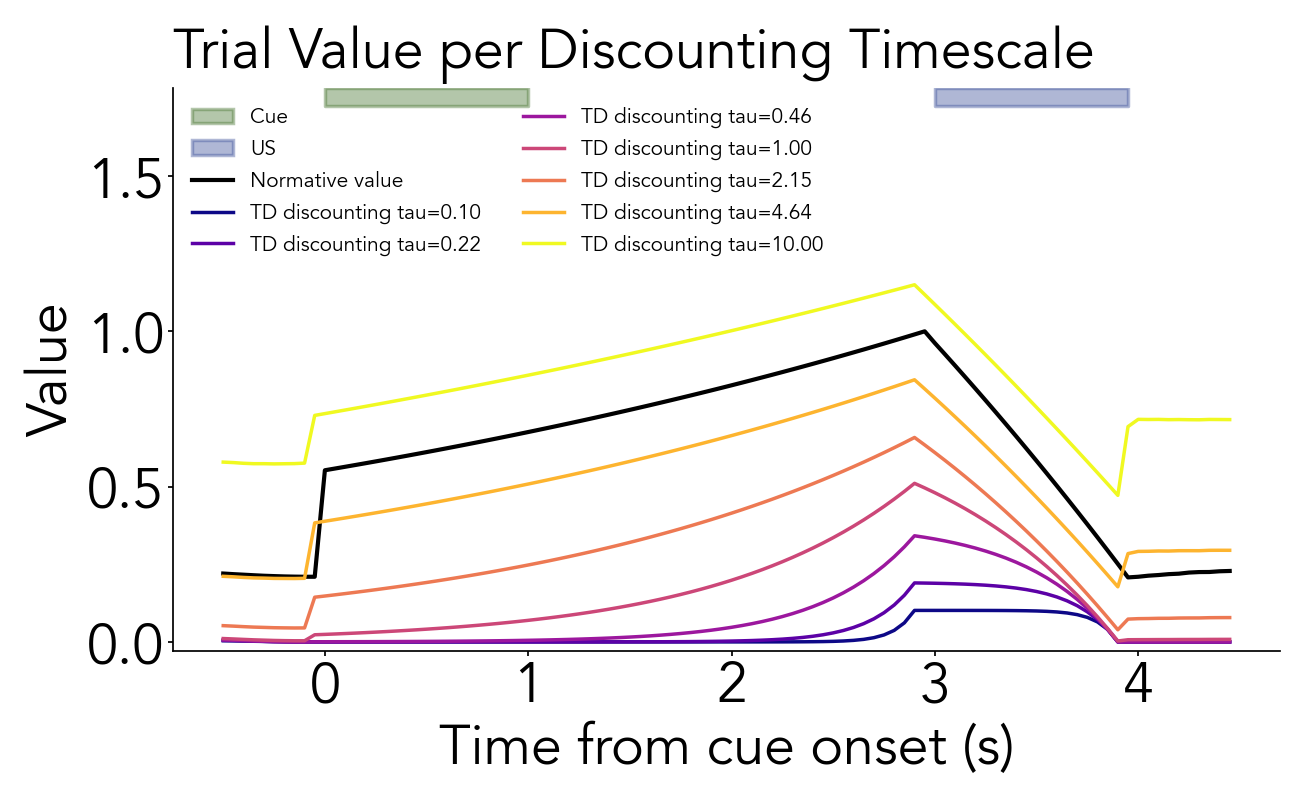

In [10]:
# Use all trial-aligned TD values for y-limits
all_trial_vals = mean_td_trials.reshape(-1)  # flatten K×T
ylim_fixer_trial = YlimFixer(all_trial_vals, label_bar_pad=0.5)

plt.figure(figsize=(5.5,3.5))
ax = plt.gca()

ax.fill_between(
    trial_t,
    ylim_fixer_trial.label_bar_bottom(),
    ylim_fixer_trial.label_bar_top(),
    where=(trial_t >= 0.) & (trial_t <= trial.cs_length *DT),
    color='#43712c', alpha=0.4, label='Cue'
)
ax.fill_between(
    trial_t,
    ylim_fixer_trial.label_bar_bottom(),
    ylim_fixer_trial.label_bar_top(),
    where=((trial_t >= (len(trial) - trial.us_length) *DT)
           & (trial_t < len(trial) *DT)),
    color='#374d97', alpha=0.4, label='US'
)

# Normative line (same for all channels)
ax.plot(trial_t, mean_norm, 'k-', linewidth=1.2, label='Normative value')


for tau_k, mean_td, col in zip(discount_timescales, mean_td_trials, colors):
    ax.plot(trial_t, mean_td, color=col, linewidth=1.0,
            label=f"TD discounting tau={tau_k:.2f}")

ylim_fixer_trial.fix_ylim(ax)
ax.set_xlabel("Time from cue onset (s)")
ax.set_ylabel("Value")
ax.legend(fontsize=6, loc="upper left", ncol=2)
plt.title("Trial Value per Discounting Timescale")
plt.tight_layout()
plt.show()

## Figure 2

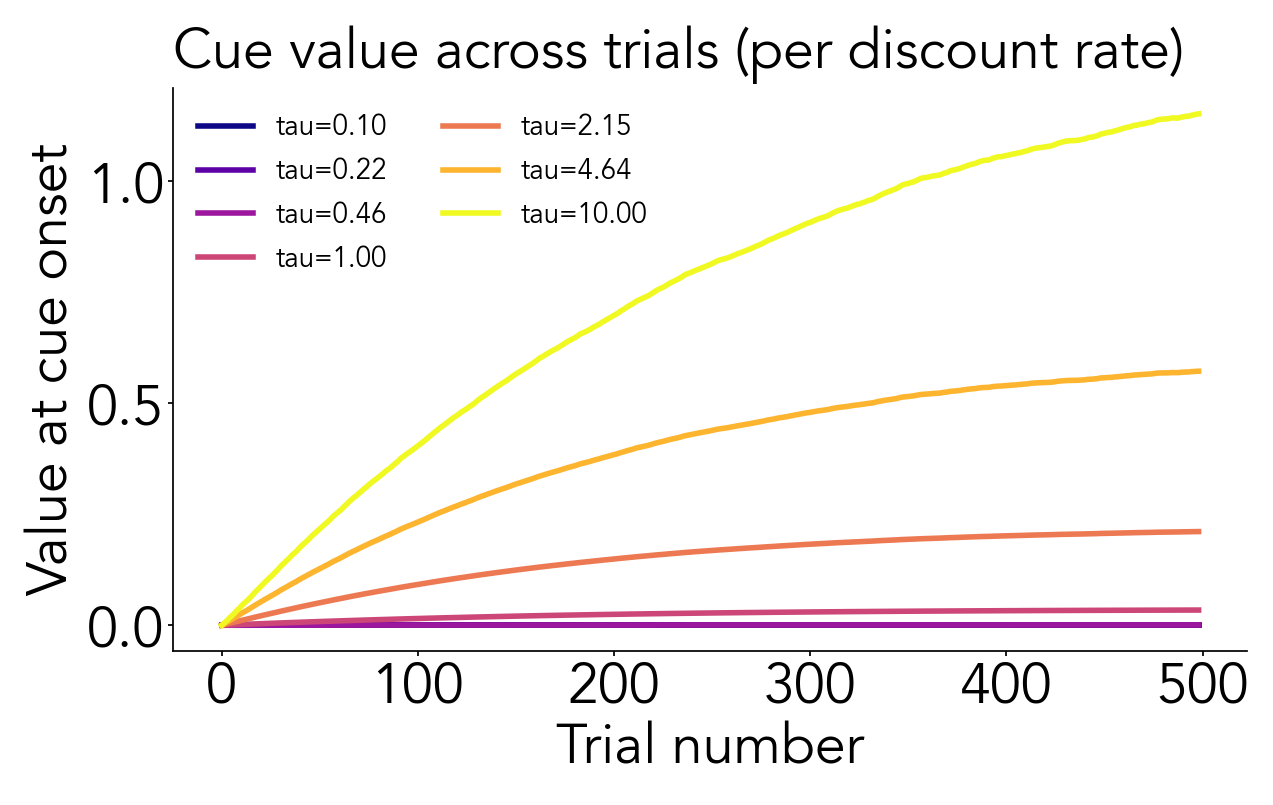

In [11]:
baseline_duration = 10
taus = np.asarray(discount_timescales)

stacked_by_tau = []
for k in range(values.shape[1]):
    stacked_td = stack_trials(
        values[:, k],
        experience.states,
        iti_state,
        len(trial),
        baseline_duration,
    )
    stacked_by_tau.append(stacked_td)

stacked_by_tau = np.array(stacked_by_tau)
# shape: (K, num_trials, T_within_trial)

K, num_trials, T_within = stacked_by_tau.shape
trial_idx = np.arange(num_trials)

idx_cue = baseline_duration  # cue onset

def smooth(x, w=15):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="same")

plt.figure(figsize=(5.5,3.5))

for k, (tau, col) in enumerate(zip(taus, colors)):
    v_cue = stacked_by_tau[k, :, idx_cue]
    plt.plot(
        trial_idx[:-1],
        v_cue[:-1   ],
        color=col,
        linewidth=1.6,
        label=f"tau={tau:.2f}"
    )

plt.xlabel("Trial number")
plt.ylabel("Value at cue onset")
plt.title("Cue value across trials (per discount rate)")
plt.legend(ncol=2, fontsize=8)
plt.savefig(
    "figure.png",
    dpi=300,              # publication quality
    bbox_inches="tight",  # removes extra whitespace
    transparent=False
)
plt.tight_layout()

plt.show()

## Now looking into using the Prospective code

In [12]:
filtered_true = neural_filter(
    v_norm,
    adaptation_timescale=1./DT,
    adaptation_strength=3,
    normalize_steady_state=True,
)

In [13]:
# 1) Stack RAW normative and TD first (trial-aligned, no filter yet)
stacked_norm_raw = stack_trials(
    v_norm,
    experience.states,
    iti_state,
    len(trial),
    baseline_duration,
)  # (num_trials, T_within_trial)

mean_norm_raw = np.nanmean(stacked_norm_raw, axis=0)

# 2) Filter per trial (reset adaptation each trial)
def filter_trials(stacked,DT, adaptation_strength=3.0):
    # stacked: (num_trials, T_within_trial)
    out = np.empty_like(stacked)
    for i in range(stacked.shape[0]):
        # handle NaNs if baseline padding introduces them
        x = stacked[i].copy()
        # replace NaNs with 0 (or last valid) so filter doesn't explode
        nanmask = np.isnan(x)
        if nanmask.any():
            x[nanmask] = 0.0
        out[i] = neural_filter(
            x,
            adaptation_timescale=1.0 /DT,     # keep your setting for now
            adaptation_strength=adaptation_strength,
            normalize_steady_state=True,
        )
        # restore NaNs if you want
        if nanmask.any():
            out[i][nanmask] = np.nan
    return out

stacked_norm = filter_trials(stacked_norm_raw,DT, adaptation_strength=3.0)
mean_norm = np.nanmean(stacked_norm, axis=0)

# 3) TD channels
mean_td_trials = []
error_trials = []
rmse_per_tau = []

values = dist_result.values
K = values.shape[1]

for k in range(K):
    td_k = values[:, k]

    stacked_td_raw = stack_trials(
        td_k,
        experience.states,
        iti_state,
        len(trial),
        baseline_duration,
    )  # (num_trials, T_within_trial)

    stacked_td = filter_trials(stacked_td_raw,DT, adaptation_strength=3.0)
    mean_td = np.nanmean(stacked_td, axis=0)

    err = mean_td - mean_norm
    rmse = np.sqrt(np.nanmean(err**2))

    mean_td_trials.append(mean_td)
    error_trials.append(err)
    rmse_per_tau.append(rmse)

mean_td_trials = np.array(mean_td_trials)
error_trials = np.stack(error_trials, axis=0)
rmse_per_tau = np.array(rmse_per_tau)

# Figure 6

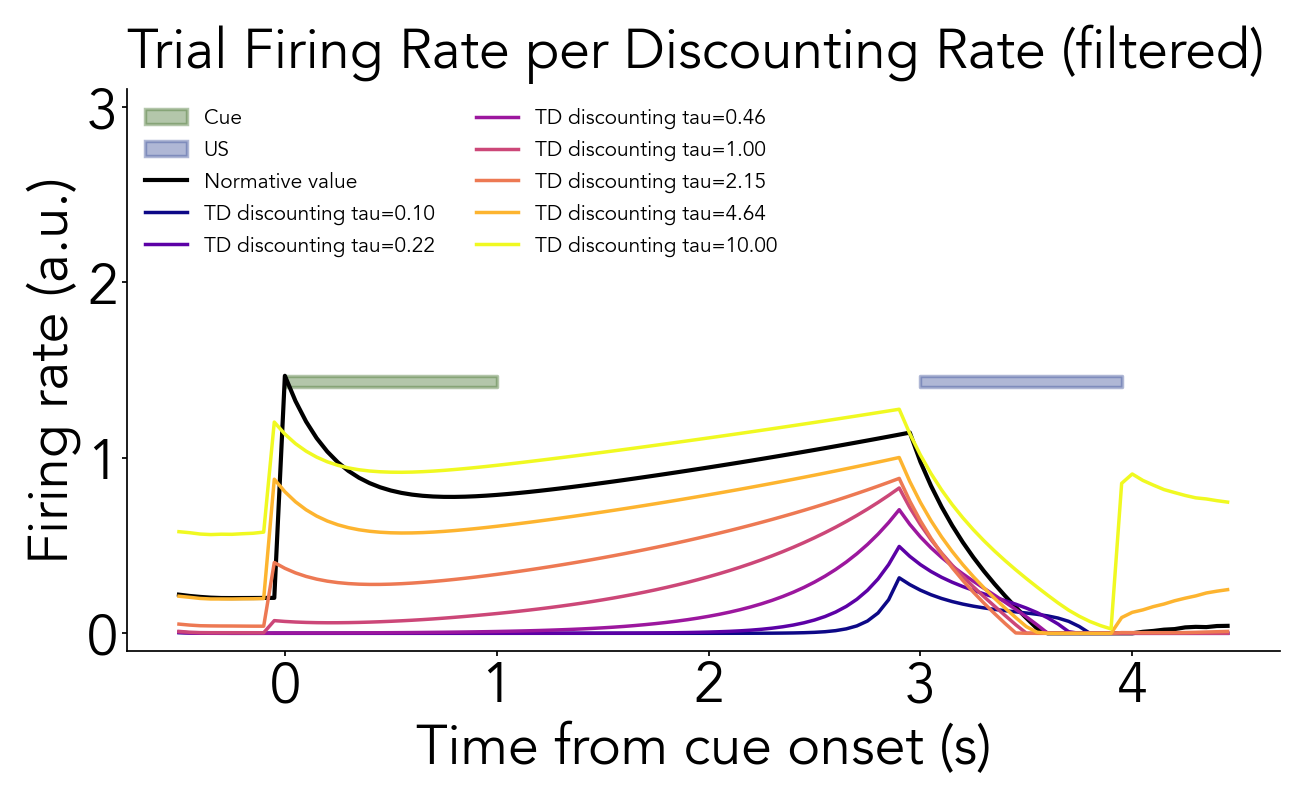

In [ ]:
# Use all trial-aligned TD values for y-limits
all_trial_vals = mean_td_trials.reshape(-1)  # flatten K×T
ylim_fixer_trial = YlimFixer(all_trial_vals, label_bar_pad=0.1)
plt.figure(figsize=(5.5,3.5))
ax = plt.gca()

ax.fill_between(
    trial_t,
    ylim_fixer_trial.label_bar_bottom(),
    ylim_fixer_trial.label_bar_top(),
    where=(trial_t >= 0.) & (trial_t <= trial.cs_length *DT),
    color='#43712c', alpha=0.4, label='Cue'
)
ax.fill_between(
    trial_t,
    ylim_fixer_trial.label_bar_bottom(),
    ylim_fixer_trial.label_bar_top(),
    where=((trial_t >= (len(trial) - trial.us_length) *DT)
           & (trial_t < len(trial) *DT)),
    color='#374d97', alpha=0.4, label='US'
)

# Normative line (same for all channels)
ax.plot(trial_t, mean_norm, 'k-', linewidth=1.2, label='Normative value')

# TD line for each timescale channel
for tau_k, mean_td, col in zip(discount_timescales, mean_td_trials, colors):
    ax.plot(trial_t, mean_td, color=col, linewidth=1.0,
            label=f"TD discounting tau={tau_k:.2f}")

#ylim_fixer_trial.fix_ylim(ax)
ax.set_ylim(-0.1, 3.1)
ax.set_xlabel("Time from cue onset (s)")
ax.set_ylabel("Firing rate (a.u.)")
ax.legend(fontsize=6, loc="upper left", ncol=2)
plt.title("Trial Firing Rate per Discounting Rate (filtered)")
plt.savefig(
    "figure.png",
    dpi=300,              # publication quality
    bbox_inches="tight",  # removes extra whitespace
    transparent=False
)
plt.tight_layout()
plt.show()

## Performing the Same Steps as above but for random tau dist to put into a heatmap

In [15]:
experience, state_matrix, rewards, trial, iti_state = set_up_trace_conditioning_simulation()
iti_len_timesteps = len(trial) * 2

Simulating trials:   0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
experience, state_matrix, rewards, trial, iti_state = set_up_trace_conditioning_simulation()
iti_len_timesteps = len(trial) * 2

N_TAUS = 80  


taus_random = np.random.uniform(low=1e-3, high=10, size=N_TAUS)
lambda_ = 0.995
alpha   = 0.01

# To run only the first N learning steps, truncate the experience.
MAX_TD_STEPS = None  # e.g., 5000

if MAX_TD_STEPS is None:
    sm_for_td = state_matrix
    r_for_td  = rewards
else:
    sm_for_td = state_matrix[:MAX_TD_STEPS]
    r_for_td  = rewards[:MAX_TD_STEPS]

# Run distributional TD:
# dist_result.values has shape (T_used, K) where K = len(taus_random)
dist_result = heterogeneous_discount_true_online_td(
    state_matrix=sm_for_td,
    rewards=r_for_td,
    taus=taus_random,  # discounting timescales τ_k
    dt=DT,                     # timestep size
    lambda_=lambda_,
    learning_rate=alpha,
)
v_dist = dist_result.values  # (T_used, K)


Simulating trials:   0%|          | 0/500 [00:00<?, ?it/s]

Applying the adaptive code

In [151]:
ADAPT_STRENGTH = 3.0

# filtered_dist will store a filtered (prospective-coded) version of each channel
filtered_dist = np.zeros_like(v_dist)

for k in range(v_dist.shape[1]):
    filtered_dist[:, k] = neural_filter(
        v_dist[:, k],
        adaptation_timescale=1.0 /DT,
        adaptation_strength=ADAPT_STRENGTH,
        normalize_steady_state=True,
    )


## Creating the DF used within the heatmap

In [ ]:

BASELINE_STEPS = 10  # steps before cue

# We need states aligned to whatever length we trained TD on:
states_for_td = experience.states[:filtered_dist.shape[0]]

# Probe stack_trials once to learn the true within-trial length 
probe_stacked = stack_trials(
    filtered_dist[:, 0],   # first tau channel
    states_for_td,
    iti_state,
    len(trial),
    BASELINE_STEPS,
)

# probe_stacked should be (num_trials, T_WITHIN_TRUE)
T_WITHIN_TRUE = probe_stacked.shape[1]

# allocate using the TRUE within-trial length
mean_by_tau = np.zeros((len(taus_random), T_WITHIN_TRUE))

# Fill the first row from the probe to avoid recomputing
mean_by_tau[0, :] = np.nanmean(probe_stacked, axis=0)

# Do the rest of taus
for k in range(1, len(taus_random)):
    stacked = stack_trials(
        filtered_dist[:, k],
        states_for_td,
        iti_state,
        len(trial),
        BASELINE_STEPS,
    )
    mean_by_tau[k, :] = np.nanmean(stacked, axis=0)

# Build time axis that matches T_WITHIN_TRUE
time_from_cue = (np.arange(T_WITHIN_TRUE) - BASELINE_STEPS) *DT

# DataFrame (rows=tau, cols=time)
df = pd.DataFrame(
    data=mean_by_tau,
    index=np.round(taus_random, 6),
    columns=np.round(time_from_cue, 6),
)
df.index.name = "tau"
df.columns.name = "time_from_cue_s"

df.head()

time_from_cue_s,-0.50,-0.45,-0.40,-0.35,-0.30,-0.25,-0.20,-0.15,-0.10,-0.05,...,4.00,4.05,4.10,4.15,4.20,4.25,4.30,4.35,4.40,4.45
tau,,,,,,,,,,,,,,,,,,,,,
9.626308,0.619656,0.619878,0.616441,0.617793,0.624611,0.627607,0.633406,0.638129,0.648069,1.380763,...,1.253964,1.178279,1.118516,1.065912,1.026121,0.991173,0.963019,0.944347,0.924620,0.908380
5.667924,0.288635,0.288816,0.288213,0.290100,0.292715,0.295186,0.297465,0.299732,0.304247,1.098298,...,0.459420,0.455043,0.454806,0.451905,0.454277,0.453371,0.452501,0.456762,0.456301,0.455129
6.809371,0.384229,0.384160,0.382680,0.384523,0.388488,0.391363,0.395189,0.398253,0.404807,1.208151,...,0.711999,0.685068,0.665847,0.646759,0.635501,0.623098,0.612724,0.609086,0.601942,0.595441
2.092135,0.030619,0.030822,0.030998,0.031499,0.031645,0.031998,0.032096,0.032214,0.032662,0.398224,...,0.007244,0.006858,0.006630,0.006272,0.006413,0.007071,0.008496,0.010360,0.012083,0.013619
5.731848,0.293950,0.294115,0.293451,0.295326,0.298049,0.300542,0.302927,0.305212,0.309872,1.105324,...,0.473814,0.468172,0.466976,0.463160,0.464711,0.463202,0.461788,0.465571,0.464705,0.463206


In [ ]:
def normalize_mean_by_tau(
    mean_by_tau: np.ndarray,      # shape (K, T)
    baseline_duration: int,       # number of pre-cue bins
    eps: float = 1e-8
) -> np.ndarray:
    """
    Normalize each tau's timecourse by its own baseline mean
    (fold-change normalization).

    Returns array of same shape (K, T), baseline ~ 1.
    """
    mean_by_tau = mean_by_tau.copy()

    # Compute baseline mean per tau
    baseline = mean_by_tau[:, :baseline_duration].mean(
        axis=1, keepdims=True
    )

    # Fold-change normalization
    mean_by_tau /= (baseline + eps)

    return mean_by_tau

### The below code is used to make it match as closely to the heatmap provided by Emerson et al 

In [154]:
def normalize_to_range_0_4(M, eps=1e-12):
    """
    Rescales the entire matrix M to [0, 4] using global min/max.
    This makes the colormap behave like the 'Firing (norm.)' plot where
    low=blue, mid=white-ish, high=red.
    """
    mmin = np.nanmin(M)
    mmax = np.nanmax(M)
    if (mmax - mmin) < eps:
        return np.zeros_like(M)
    out = (M - mmin) / (mmax - mmin)  # -> [0,1]
    return 4.0 * out                  # -> [0,4]

In [155]:
M_plot = normalize_mean_by_tau(mean_by_tau, baseline_duration=BASELINE_STEPS-1)

# Figure 8

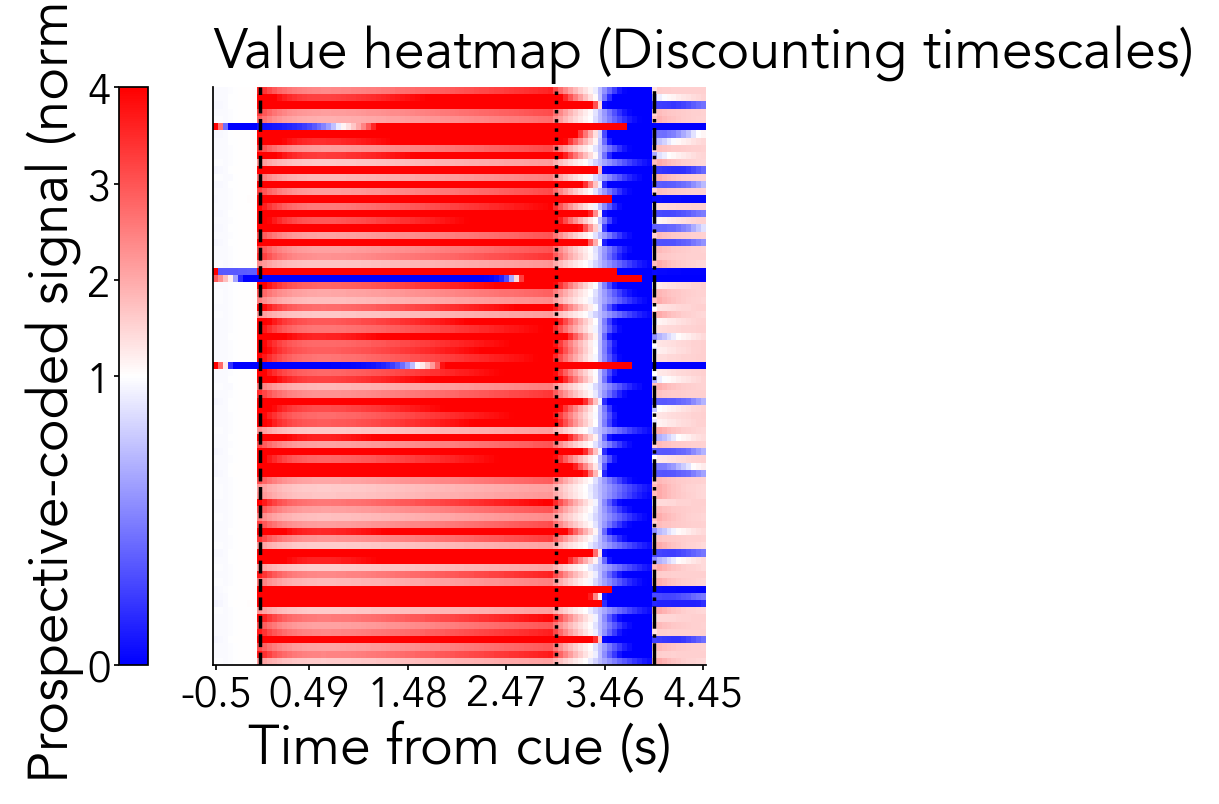

In [ ]:
norm = TwoSlopeNorm(
    vmin=0.0,   # blue
    vcenter=1.0,  # white
    vmax=4.0,   # red
)

plt.figure(figsize=(3.5, 3.5))

im = plt.imshow(
    M_plot,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="bwr",
    norm=norm, 
)

plt.colorbar(im, location = "left", label="Prospective-coded signal (norm.)")

# Vertical lines:
# cue onset is at column BASELINE_STEPS (time = 0)
plt.axvline(BASELINE_STEPS-1, color="k", linestyle="--", linewidth=1, label="Cue onset")

# Reward onset occurs after cue + trace (in steps):
# cue starts at t=0 and lasts cs_length steps, then trace_length steps, then reward (us_length) starts.
reward_onset_step = BASELINE_STEPS + int(trial.cs_length + trial.trace_length)- 1
plt.axvline(reward_onset_step, color="k", linestyle=":", linewidth=1, label="Reward onset")

# ITI start (end of trial) is at baseline + len(trial)
iti_start_step = BASELINE_STEPS + len(trial) -1
plt.axvline(iti_start_step, color="k", linestyle="-.", linewidth=1, label="ITI start")

# Axis labels
plt.xticks(
    ticks=np.linspace(0, T_WITHIN_TRUE- 1, 6, dtype=int),
    labels=np.round(np.linspace(time_from_cue[0], time_from_cue[-1], 6), 2),
)
plt.yticks([])

plt.xlabel("Time from cue (s)")
plt.ylabel(" ")
plt.title(f"Value heatmap (Discounting timescales)")
plt.tight_layout()
plt.show()